In [1]:
import f_processing as dp
# from pyspark.ml.regression import RandomForestRegressor


In [2]:
df1991, df2001 = dp.load_data()

In [3]:
df1991, df2001 = dp.preprocessing(df1991,df2001)

In [4]:
pdf_91 = dp.preprocess_data(df1991,['UniqueCarrier','Origin','Dest'],['Month','DayofMonth','DayOfWeek','DepTime','CRSDepTime','ArrTime','CRSArrTime','FlightNum','ActualElapsedTime','CRSElapsedTime','DepDelay','Distance','Cancelled','Diverted'])

In [5]:
pdf_91.limit(10).show()

+-------------+------+----+-----+----------+---------+-------+----------+-------+----------+---------+-----------------+--------------+--------+--------+---------+--------+--------------------+------+
|UniqueCarrier|Origin|Dest|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|FlightNum|ActualElapsedTime|CRSElapsedTime|DepDelay|Distance|Cancelled|Diverted|            features|target|
+-------------+------+----+-----+----------+---------+-------+----------+-------+----------+---------+-----------------+--------------+--------+--------+---------+--------+--------------------+------+
|           US|   TPA| SYR|    1|         1|        2| 1709.0|      1705| 1944.0|      1944|      112|            155.0|           159|     4.0|  1104.0|        0|       0|(490,[0,42,302,47...|     0|
|           US|   TPA| SYR|    1|         2|        3| 1704.0|      1705| 1946.0|      1944|      112|            162.0|           159|    -1.0|  1104.0|        0|       0|(490,[0,42,302,47...|   

In [6]:
pdf_01 = dp.preprocess_data(df2001,['UniqueCarrier','TailNum','Origin','Dest'],['Month','DayofMonth','DayOfWeek','DepTime','CRSDepTime','ArrTime','CRSArrTime','FlightNum','ActualElapsedTime','CRSElapsedTime','DepDelay','Distance','TaxiIn','TaxiOut','Cancelled','Diverted'])

In [7]:
pdf_01.show(5)

+-------------+-------+------+----+-----+----------+---------+-------+----------+-------+----------+---------+-----------------+--------------+--------+--------+------+-------+---------+--------+--------------------+------+
|UniqueCarrier|TailNum|Origin|Dest|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|FlightNum|ActualElapsedTime|CRSElapsedTime|DepDelay|Distance|TaxiIn|TaxiOut|Cancelled|Diverted|            features|target|
+-------------+-------+------+----+-----+----------+---------+-------+----------+-------+----------+---------+-----------------+--------------+--------+--------+------+-------+---------+--------+--------------------+------+
|           US| N700äæ|   BWI| CLT|    1|        17|        3| 1806.0|      1810| 1931.0|      1934|      375|             85.0|          84.0|    -4.0|     361|     5|     20|      0.0|     0.0|(5048,[4,1374,459...|     0|
|           US| N713äæ|   BWI| CLT|    1|        18|        4| 1805.0|      1810| 1938.0|      1934|    

In [8]:
train_91, test_91 = pdf_91.randomSplit([0.8, 0.2], seed=42)

In [9]:
rf_91 = dp.train_and_evaluate(train_91,test_91)

In [10]:
rf_91.get('accuracy')

0.6847680301620388

In [11]:
# dp.plot_accuracy_bar_chart(rf_91.get('accuracy'), xgb_91.get('accuracy'))

In [12]:
train_01, test_01 = pdf_01.randomSplit([0.8, 0.2], seed=42)

In [13]:
rf_01 = dp.train_and_evaluate(train_01,test_01)

In [53]:
def calculate_feature_importance(trained_model, train_data):
    
    
    # Get feature importances
    importances = trained_model.featureImportances.toArray()

    # Get the names of the input features used in the model
    input_features = train_data.schema["features"].metadata["ml_attr"]["attrs"]["binary"] + \
                    train_data.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]
    # Mapping for categorical features
    original_to_encoded_mapping = {}

    for feature_info in input_features:
        encoded_feature_name = feature_info['name']
        if '_encoded_' in encoded_feature_name:
            original_feature = encoded_feature_name.split('_encoded_')[0]
            if original_feature not in original_to_encoded_mapping:
                original_to_encoded_mapping[original_feature] = []
            original_to_encoded_mapping[original_feature].append(encoded_feature_name)

    # Create a dictionary to map original features to their respective encoded features
    original_feature_importances = {}
    for original_feature, encoded_features in original_to_encoded_mapping.items():
        importance_sum = 0.0
        for encoded_feature in encoded_features:
            idx = [feature['name'] for feature in input_features].index(encoded_feature)
            importance_sum += importances[idx]
        original_feature_importances[original_feature] = importance_sum

    # Map numeric features and their importances
    numeric_features = [feature['name'] for feature in input_features if '_encoded_' not in feature['name']]
    for numeric_feature in numeric_features:
        idx = [feature['name'] for feature in input_features].index(numeric_feature)
        original_feature_importances[numeric_feature] = importances[idx]

    # Calculate the total importance sum for normalization
    total_importance = sum(original_feature_importances.values())

    feature_importance_list = []
    for feature, importance in original_feature_importances.items():
        importance_percentage = (importance / total_importance) * 100
        feature_importance_list.append({'Feature': feature, 'Importance': importance_percentage})

    feature_importance_df = pd.DataFrame(feature_importance_list).sort_values(by='Importance', ascending=False)
    return feature_importance_df

In [54]:
import pandas as pd

In [82]:
df = calculate_feature_importance(rf_model.stages[-1], train_91)

In [81]:
df

,Feature,Importance
13,DepDelay,31.936338
11,ActualElapsedTime,13.585017
0,UniqueCarrier,12.598232
1,Origin,11.071603
6,DepTime,8.057729
8,ArrTime,5.954684
2,Dest,5.473170
9,CRSArrTime,2.805816
3,Month,2.401353
7,CRSDepTime,1.671531


In [83]:
df

,Feature,Importance
13,DepDelay,31.936338
11,ActualElapsedTime,13.585017
0,UniqueCarrier,12.598232
1,Origin,11.071603
6,DepTime,8.057729
8,ArrTime,5.954684
2,Dest,5.473170
9,CRSArrTime,2.805816
3,Month,2.401353
7,CRSDepTime,1.671531


In [79]:
import matplotlib.pyplot as plt

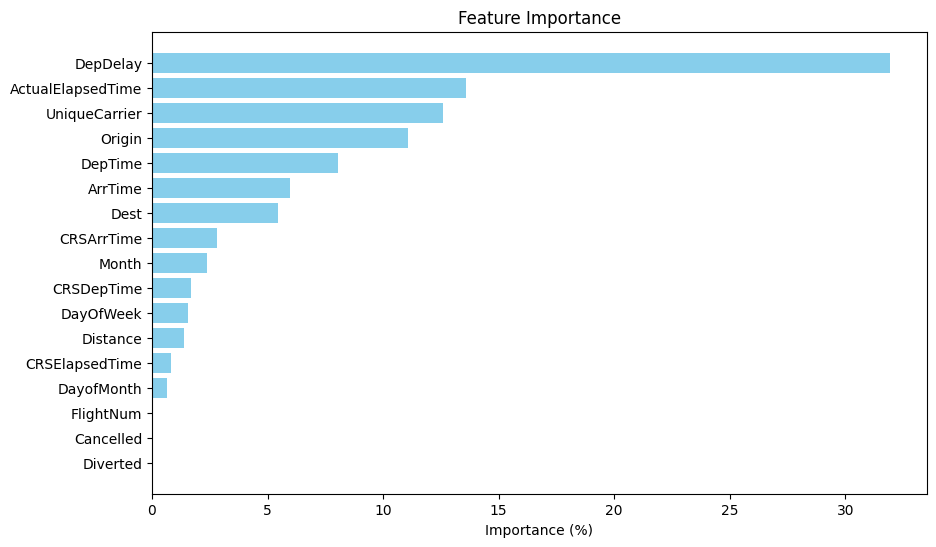

In [80]:
plt.figure(figsize=(10, 6))
plt.barh(df['Feature'], df['Importance'], color='skyblue')
plt.xlabel('Importance (%)')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature on top
plt.show()